## Initial loading of libraries and dataset

In [1]:
# Load the initial modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Read the existing datasets (https://www.kaggle.com/competitions/titanic/data)
train_data = pd.read_csv("train.csv", index_col='PassengerId')
X_test = pd.read_csv("test.csv")

## Explore the data

In [3]:
# Output the initial data
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Check for missing values
train_data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# Get a summary of the dataset
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


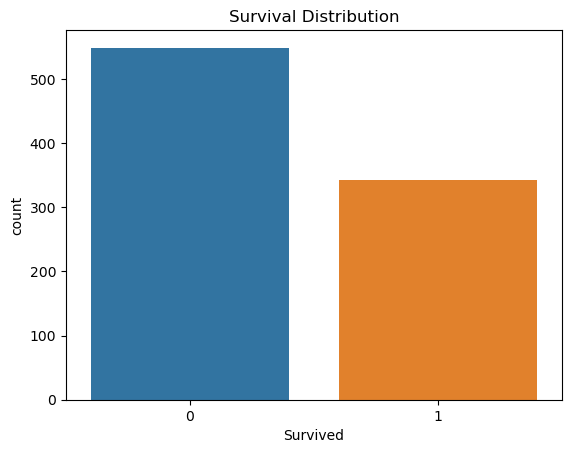

In [6]:
# Visualize the distribution of quality
sns.countplot(x='Survived', data=train_data)
plt.title('Survival Distribution')
plt.show()

## Preprocess the data

In [7]:
# Drop columns that won't be useful
train_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# Separate features and target
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Get list of categorical variables
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == 'object']

# Count the unique values for categorical variables
unique_categorical = {col: X_train[col].nunique() for col in categorical_cols} 
print(unique_categorical)

{'Sex': 2, 'Embarked': 3}


In [8]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

def get_score(model):
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(clf, X_train, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    return scores.mean()

## Train first model

{50: 0.2426097492262862, 100: 0.2433786800275073, 150: 0.2422902968370418, 200: 0.24181711698407896, 250: 0.24206133277755976, 300: 0.2420936849142068, 350: 0.24183495333542596, 400: 0.24250129383345592}


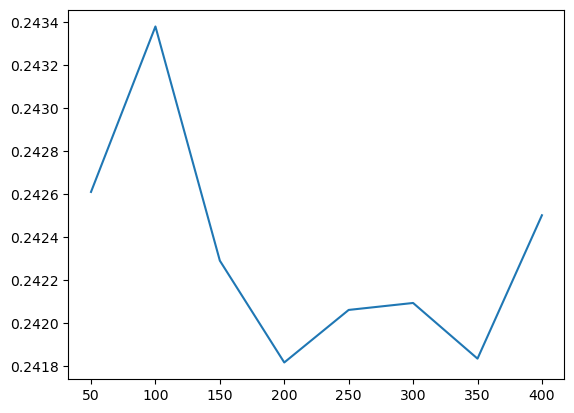

In [9]:
# Test different n_estimators
results = {i: get_score(RandomForestRegressor(n_estimators=i, random_state=0)) for i in range(50, 401, 50)}
print(results)

# Visualize result
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [10]:
# Define a pipeline with preprocessing and model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestRegressor(random_state=0))
                     ])

param_grid = {
    'model__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

# Grid search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best MAE score:", -grid_search.best_score_)

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best MAE score: 0.24181711698407896


## Predict with first model

In [11]:
# Best RandomForestRegressor model
best_model1 = RandomForestRegressor(random_state=0, n_estimators=200)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', best_model1)
                     ])
# Fit model 
clf.fit(X_train, y_train)
# Get predictions
preds_test1 = clf.predict(X_test)
binary_predictions1 = (preds_test1 > 0.5).astype(int)
# Save test predictions to file
output_1 = pd.DataFrame({'PassengerId': X_test.PassengerId,
                       'Survived': binary_predictions1})
output_1.to_csv('submission1.csv', index=False)

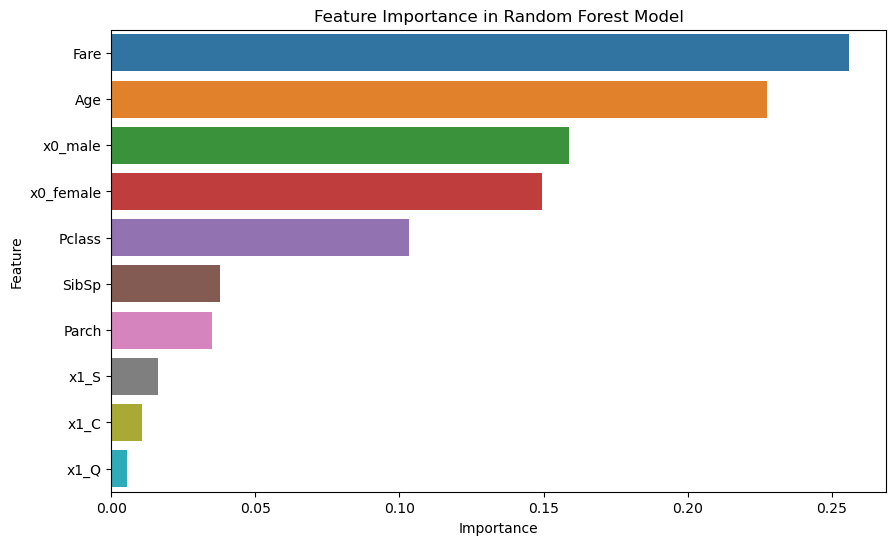

In [12]:
# Retrieve feature importance
feature_importances = clf.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
feature_names = numerical_cols + list(clf.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.show()

## Train second model

In [13]:
# Create the model
model_2 = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5)

# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='constant')
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])

# Handling missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])

# One-hot encoding for categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])

# Combine numerical and encoded categorical features
X_train_final = np.hstack((X_train[numerical_cols].values, X_train_encoded))

# Splitting the data into training and validation sets
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_final, y_train, train_size=0.8, test_size=0.2, random_state=0)

# Fit the model on the training set
model_2.fit(X_train_part, y_train_part,
            eval_set=[(X_valid, y_valid)], 
            verbose=False)

# Get predictions
predictions_2 = model_2.predict(X_valid)

# Calculate MAE
mae = mean_absolute_error(y_valid, predictions_2)

# Print MAE
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.24457554306897372


## Predict with second model

In [14]:
# Fit model 
model_2.fit(X_train_final, y_train,
            eval_set=[(X_valid, y_valid)], 
            verbose=False)
# Get predictions
preds_test2 = model_2.predict(pd.DataFrame(preprocessor.transform(X_test), columns=feature_names))
binary_predictions2 = (preds_test2 > 0.5).astype(int)
# Save test predictions to file
output_2 = pd.DataFrame({'PassengerId': X_test.PassengerId,
                       'Survived': binary_predictions2})
output_2.to_csv('submission2.csv', index=False)